In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import csv

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

from keras import layers
from keras.models                      import Model, load_model, Sequential
from keras.applications.vgg16          import VGG16
from keras.applications.vgg16          import decode_predictions
from keras.utils.np_utils              import to_categorical

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [4]:
limit_mem()

In [5]:
def create_title(category):
    return '"%s"' % (category) 

In [6]:
def generate_title(model, array):
    prediction = model.predict(array).argmax()
    category = labels[prediction]
    return create_title(category)

In [7]:
filename = '../../Images/stop2.jpeg'

(1, 100, 100, 3)


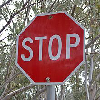

In [8]:
original_pic   = Image.open(filename).resize((100, 100))
original_array = np.expand_dims(np.array(original_pic), 0)
print(original_array.shape)
original_pic

We transform the image according to the VGG16 requirements. It consists in substracting the mean value for each channel and reversing the order of the channels. 

# Labels

In [9]:
def readTrafficSigns(file_path):
    labels = [] # corresponding labels
    if os.path.isfile(file_path):
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',') # csv parser for annotations file 
            # loop over all images in current annotations file
            for row in csv_reader:
                labels.append(row[1]) # the second column is the label
            csv_file.close()
    return labels[1:]

In [10]:
labels = readTrafficSigns("../../VGG16/signnames.csv")

# Goal

The goal of this notebook is to implement the "fast gradient sign method" presented in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). This method is used to modify classical samples that a deep neural network trained classification will fail to classify properly.

![fgsm idea](http://karpathy.github.io/assets/break/breakconv.png "Fast Gradient Sign Method")

The idea of this method is to take a sample, ask the network to classify it, compute the gradient of the loss in function of the input pixels and update the picture by a small amount in the direction of the gradient. This direction is opposite to the one that would increase the score for the correct class.

In [11]:
imagenet_mean      = np.array([123.68, 116.779, 103.939], dtype = np.float32)
preprocess         = lambda x: (x - imagenet_mean)
deprocess          = lambda x: (x + imagenet_mean)
preprocessed_array = preprocess(original_array)

# VGG loading

## Loading Fine-tuned VGG16 model

In [12]:
model              = load_model('../../Models/VGG16/model_pur_transfer_GTSRB_77.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
Dropout_Dense_1 (Dropout)    (None, 256)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
Dropout_Dense_2 (Dropout)    (None, 512)               0         
_________________________________________________________________
Softmax (Dense)              (None, 43)                22059     
Total para

Now let's ask the network what he sees in the picture. 

In [13]:
pred = model.predict(original_array).argmax()
print("Clean prediction : %s"%(labels[pred]))

Clean prediction : Stop


# Adversarial example generation

Now we try to confuse the network by modifying the brocoli picture. We first compute the derivatives of the loss function according to the pixels of the image.

In [14]:
target_idx      = model.predict(original_array).argmax()
target          = to_categorical(target_idx, 43)
target_variable = K.variable(target)
loss            = metrics.categorical_crossentropy(model.output, target_variable)
gradients       = K.gradients(loss, model.input)
get_grad_values = K.function([model.input], gradients)
grad_values     = get_grad_values([original_array])[0]

As mentioned in the article, we will just use the signs of the derivatives.

In [15]:
grad_signs = np.sign(grad_values)

Now we multiply these values by a very small number and add them to the pixel values of the original image. The conversion to uint8 is necessary to get a proper display using imshow ([Stackoverflow](https://stackoverflow.com/questions/39925420/bizzare-matplotlib-behaviour-in-displaying-images-cast-as-floats)). We also clip the values to the interval [0, 255] to get a valid image.

In [16]:
epsilon         = 4
perturbation    = grad_signs * epsilon
modified_array  = preprocessed_array + perturbation
deprocess_array = np.clip(deprocess(modified_array), 0., 255.).astype(np.uint8)

In [17]:
title_original     = generate_title(model, preprocessed_array)
title_perturbation = create_title("Perturbation")
title_modified     = generate_title(model, modified_array)

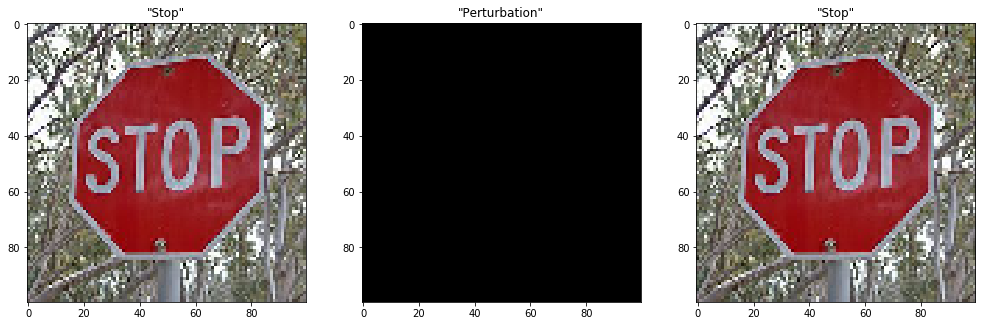

In [18]:
plt.figure(figsize = (17, 17))
plt.subplot(1, 3, 1)
plt.imshow(original_array[0])
plt.title(title_original)
plt.subplot(1, 3, 2)
plt.imshow(perturbation[0])
plt.title(title_perturbation)
plt.subplot(1, 3, 3)
plt.imshow(deprocess_array[0])
plt.title(title_modified)

In [19]:
print('mean value of perturbation:', perturbation.mean())
pred = model.predict(deprocess_array).argmax()
print("Adversarial prediction : %s"%(pred))


mean value of perturbation: 0.0
Adversarial prediction : 14
